# Car Price Prediction using Linear Regression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
car_price_df = pd.read_csv("./helper files/car_price_data.csv")
car_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

<AxesSubplot:xlabel='MSRP', ylabel='Count'>

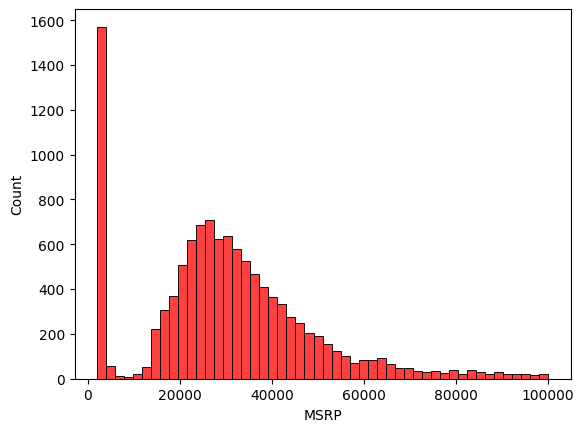

In [3]:
sns.histplot(car_price_df[car_price_df['MSRP'] < 100000]['MSRP'], color='red', legend="< 100000", bins=50)

## Cleaning the dataset

In [4]:
car_price_df.columns = car_price_df.columns.str.lower()
car_price_df.columns = car_price_df.columns.str.replace(' ', '_')

object_columns = list(car_price_df.dtypes[car_price_df.dtypes == 'object'].index)

for column in object_columns:
    car_price_df[column] = car_price_df[column].str.lower()
    car_price_df[column] = car_price_df[column].str.replace(' ', '_')

car_price_df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


## Functions to be used for the model

In [5]:
def distribute_dataframe(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    val_df_size, test_df_size = int(len(df) * 0.2), int(len(df) * 0.2)
    train_df_size = len(df) - val_df_size - test_df_size

    records_range = np.arange(len(df))
    np.random.seed(42)
    np.random.shuffle(records_range)

    train_df = df.iloc[:train_df_size]
    val_df = df.iloc[train_df_size:train_df_size+val_df_size]
    test_df = df.iloc[train_df_size+val_df_size:]

    # Resetting the indices of the data frames
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    return train_df, val_df, test_df

def prepare_X(df: pd.DataFrame, fill: int = 0) -> np.ndarray:
    features_to_use = ['year', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity']

    X = df[features_to_use]
    X = X.fillna(fill)
    X = X.values

    return X

def prepare_y(df: pd.DataFrame) -> np.ndarray:
    y = df['msrp'].values
    y = np.log1p(y)  # to reduce the long tail distribution of the MSRP distribution
    del df['msrp']
    return y

def train_linear_regression(X: np.ndarray, y: np.ndarray) -> tuple[np.float64, np.ndarray]:
    # Adding the bias values to the X to account for scenarios where no information is available
    bias_matrix = np.ones(X.shape[0])
    
    X = np.column_stack((bias_matrix, X))

    XT = X.T
    XTX = XT.dot(X)
    XTX_inv = np.linalg.inv(XTX)

    w_full = XTX_inv.dot(XT).dot(y)

    return w_full[0], w_full[1:]



In [6]:
train_df, val_df, test_df = distribute_dataframe(car_price_df)

y_train = prepare_y(train_df)
y_val = prepare_y(val_df)
y_test = prepare_y(test_df)

X_train = prepare_X(train_df)
X_val = prepare_X(val_df)

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_val.dot(w)
y_pred

array([11.07634481, 11.22988482, 11.2325765 , ..., 11.18725094,
       11.18725094, 11.19320574])

In [7]:
def calculate_rmse(y_actual: np.ndarray, y_prediction: np.ndarray) -> np.float64:
    e = y_actual - y_prediction
    se = e ** 2
    mse = np.mean(se)
    rmse = np.sqrt(mse)
    return rmse

In [8]:
rmse_train = calculate_rmse(y_val, y_pred)
rmse_train

0.5092818630324761

In [9]:
total_types: dict[str, list[int, list[str]]] = {}

for column_name, type in car_price_df.dtypes.items():
    if str(type) not in total_types:
        total_types[str(type)] = [1, [column_name]]
    else:
        total_types[str(type)][0] += 1
        total_types[str(type)][1].append(column_name)

print(f"The different types of data in the dataset are: {total_types.keys()}")


print(f"int64 columns: {total_types['int64']}")
print(f"float64 columns: {total_types['float64']}")
print(f"object columns: {total_types['object']}")

The different types of data in the dataset are: dict_keys(['object', 'int64', 'float64'])
int64 columns: [5, ['year', 'highway_mpg', 'city_mpg', 'popularity', 'msrp']]
float64 columns: [3, ['engine_hp', 'engine_cylinders', 'number_of_doors']]
object columns: [8, ['make', 'model', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style']]


In [12]:
categorical_feature_values = {}
for feature in total_types['object'][1]:
    categorical_feature_values[feature] = list(train_df[feature].value_counts().index[:5])
    
categorical_feature_values

{'make': ['ford', 'volkswagen', 'chevrolet', 'nissan', 'mazda'],
 'model': ['f-150', 'beetle_convertible', 'gti', 'frontier', 'accord'],
 'engine_fuel_type': ['regular_unleaded',
  'premium_unleaded_(required)',
  'premium_unleaded_(recommended)',
  'flex-fuel_(unleaded/e85)',
  'diesel'],
 'transmission_type': ['automatic',
  'manual',
  'automated_manual',
  'direct_drive',
  'unknown'],
 'driven_wheels': ['front_wheel_drive',
  'rear_wheel_drive',
  'all_wheel_drive',
  'four_wheel_drive'],
 'market_category': ['luxury',
  'crossover',
  'luxury,performance',
  'performance',
  'hatchback'],
 'vehicle_size': ['compact', 'midsize', 'large'],
 'vehicle_style': ['sedan',
  '4dr_suv',
  'coupe',
  'convertible',
  '4dr_hatchback']}

In [25]:
def prepare_X_improved(df: pd.DataFrame, fill=0) -> np.ndarray:
    features_to_use = ['age', 'engine_hp', 'engine_cylinders', 'number_of_doors', 'highway_mpg', 'city_mpg', 'popularity']

    X = df.copy()

    max_year = X['year'].max()    
    X['age'] = max_year - X['year']

    for cat_feature, values in categorical_feature_values.items():
        for value in values:
            X[f"{cat_feature}_{value}"] = (X[cat_feature] == value).astype(int)
            features_to_use.append(f"{cat_feature}_{value}")
    
    print(f"Using {len(features_to_use)} features for preparing feature matrix")
    
    X = X[features_to_use]

    X = X.fillna(fill)
    X = X.values

    return X

In [26]:
X_train_new = prepare_X_improved(train_df)
X_val_new = prepare_X_improved(val_df)

w0_new, w_new = train_linear_regression(X_train_new, y_train)
y_pred_new = w0 + X_val_new.dot(w_new)

rmse_new = calculate_rmse(y_val, y_pred_new)
rmse_new

Using 44 features for preparing feature matrix
Using 44 features for preparing feature matrix


2.4205768086121588e+16

In [15]:
def train_linear_regression_improved(X: np.ndarray, y: np.ndarray, r: float) -> tuple[np.float64, np.ndarray]:
    # w = XTX_inv.XT.y

    # Adding bias term to the matrix
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XT = X.T
    XTX = XT.dot(X)
    
    # Adding the regularization parameter, r to the Gram matrix to remove scenarios of linear combination
    Ir = np.eye(XTX.shape[0]) * r
    XTX = XTX + Ir

    XTX_inv = np.linalg.inv(XTX)

    w_full = XTX_inv.dot(XT).dot(y)

    return w_full[0], w_full[1:]

In [27]:
for r in [0, 0.1, 0.01, 0.001, 0.0001, 1, 10]:
    w0_imp, w_imp = train_linear_regression_improved(X_train_new, y_train, r=r)
    y_pred_imp = w0_imp + X_val_new.dot(w_imp)

    rmse_score_reg = calculate_rmse(y_val, y_pred_imp)
    print(f"RMSE Score with r: {r} is {rmse_score_reg:.4f}")

RMSE Score with r: 0 is 81.5389
RMSE Score with r: 0.1 is 0.4793
RMSE Score with r: 0.01 is 0.4794
RMSE Score with r: 0.001 is 0.4795
RMSE Score with r: 0.0001 is 0.4795
RMSE Score with r: 1 is 0.4782
RMSE Score with r: 10 is 0.4918


In [31]:
final_r = 0.1

full_train_df = pd.concat([train_df, val_df], ignore_index=True)

X_train_full = prepare_X_improved(full_train_df)
y_train_full = np.concatenate((y_train, y_val))

X_test = prepare_X_improved(test_df)

w0_comb, w_comb = train_linear_regression_improved(X_train_full, y_train_full, r=final_r)
y_pred_comb = w0_comb + X_test.dot(w_comb)

rmse_comb = calculate_rmse(y_test, y_pred_comb).round(3)
rmse_comb

Using 44 features for preparing feature matrix
Using 44 features for preparing feature matrix


0.456

## Using the model to predict the price of a car

In [47]:
car_info = test_df.iloc[20].to_dict()
actual_price = np.expm1(y_test[20]).round(2)

sample_df = pd.DataFrame([car_info])

X_sample = prepare_X_improved(sample_df)
y_small = w0_comb + X_sample.dot(w_comb)
y_small = y_small[0]
predicted_price = np.expm1(y_small).round(2)

print(f"The predicted price of a sample car is {predicted_price} while the actual price is {actual_price}")
print(f"The difference between the actual and predicted price is: {actual_price-predicted_price}")

Using 44 features for preparing feature matrix
The predicted price of a sample car is 38005.36 while the actual price is 31035.0
The difference between the actual and predicted price is: -6970.360000000001
